In [48]:
from google.cloud import bigquery
import pandas as pd
from stop_words import get_stop_words
import re
import base64
from textblob import TextBlob
from langdetect import detect
from datetime import datetime, date
def return_date(x):
    return datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').date()



def extract_hashtag(text):
    hashtag = re.findall(r"#(\w+)", text)
    return hashtag

def check_language(text):
    return detect(text)

def count_hashtag(text):
    return len(text)

def cleaner_txt(text):
    text = ''.join(text).lower()    
    ''' 
    Function to clean:
     - Http links
     - @ mention
     - special caracter
     - RT
    '''
    if (text):
        text = text.lower()    
        text =  ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(^rt)", " ", text).split()) 
        
    return text
def tokenization(text):
    return re.split('\W+', text)

def count_word(text):
    
    if isinstance(text, str):
        text = re.split('\W+', text)
        count = len(text)
    else:
        count = 0
    return count

  
def get_sentiment_description(polarity): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # set sentiment 
    if polarity > 0: 
        return 'positive'
    elif polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [52]:

client = bigquery.Client()
# Perform a query.
sql = (
    ' SELECT  '+
    'text, quote_count, reply_count, '+
    'retweet_count, favorite_count, user_screen_name, user_location, '+
    'user_verified, user_followers_count, user_friends_count, '+
    'user_listed_count, user_favourites_count, user_statuses_count, '+
    'description, '+
    'CAST(user_created_at as DATE) as date ' +
    'FROM capstonettw.tweet ' +
    'WHERE DATE(user_created_at) <= CURRENT_DATE() ' +
    'LIMIT 1'
#    ' WHERE DATE(created_at) = "2019-11-14"'
)

In [ ]:


"""Triggered from a message on a Cloud Pub/Sub topic.
Args:
     event (dict): Event payload.
     context (google.cloud.functions.Context): Metadata for the event.
"""
#pubsub_message = base64.b64decode(event['data']).decode('utf-8')

# Insert the query result into a dataframe
df = pd.read_gbq(sql, dialect='standard')

df["date"] = df.date.apply(return_date)

# Extract all the words that starts with #
df["hashtags"] = df.text.apply(extract_hashtag)
df["hashtags_count"]  = df.hashtags.apply(count_hashtag)

# Use regex to clean the text
df["text"] = df.text.apply(cleaner_txt) 

df["description"] = df.description.apply(cleaner_txt) 



df.drop(df[df.text ==''].index, inplace=True)
df['lang'] = df.text.apply(check_language)



df.drop(df[df.lang !='en'].index, inplace=True)

del df['lang']
df.drop_duplicates(subset=['user_screen_name', 'text'], keep='first', inplace=False)

try:
    def remove_stop_word(word_list):
        filter_word =  [w for w in word_list if not w in stop_words]

        return  ' '.join(filter_word)

    stop_words = list(get_stop_words('en'))         
except Exception as e:
    print(e)

# Split the sentence into a array of words
df['text'] = df['text'].apply(tokenization)
# Remove Stop words
df['text'] = df.text.apply(remove_stop_word)

df['polarity'] = 0.0
df['subjectivity'] = 0.0

df[['polarity', 'subjectivity']] = df['text'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

df['sentiment'] = df.polarity.apply(get_sentiment_description)

df["creation_days"] = df.date.apply(lambda x: (date.today() - x).days)

df['description_count'] = df.description.apply(count_word)



In [ ]:


try:
    #table_id = os.environ['TABLE_ID']
    #project_id = os.environ['PROJECT_ID']
    #df.to_gbq(destination_table="capstonettw.sentiment", project_id="heroic-gamma-254018", if_exists='append')
except Exception as e:
    print(e)


In [54]:
df.head()

,text,quote_count,reply_count,retweet_count,favorite_count,user_screen_name,user_location,user_verified,user_followers_count,user_friends_count,user_listed_count,user_favourites_count,user_statuses_count,description,date,hashtags,hashtags_count


In [44]:
len(df)

9573

In [45]:

print(len(df))

5405


,text,quote_count,reply_count,retweet_count,favorite_count,user_screen_name,user_location,user_verified,user_followers_count,user_friends_count,user_listed_count,user_favourites_count,user_statuses_count,description,date,hashtags,hashtags_count,lang
0,looking forward to speaking at the national bl...,0,0,67,264,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2017-12-04,[],0,en
2,flashbackfriday to learning from amp his visio...,0,0,104,506,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2017-11-17,[],0,en
3,very sad news out of paris with a catastrophic...,0,0,50,315,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2019-04-15,[],0,en
4,i started with the dictionary wink wingk verb ...,0,0,1,33,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2019-01-04,[],0,en
5,what when was it,0,0,0,1,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2017-11-26,[],0,en
6,on worldhumanitarianday we show support for hu...,0,0,44,114,theJagmeetSingh,Canada,True,266303,1428,1060,2676,11751,pronounced jug like hug meet leader of canada ...,2019-08-19,[],0,en
7,did you get your flu shot yet i got mine today...,0,0,265,1722,JustinTrudeau,Papineau,True,4639652,948,13819,111,26166,father husband 23rd prime minister of canada a...,2019-11-20,[],0,en
11,at the same time we ve created over one millio...,0,0,36,162,JustinTrudeau,Papineau,True,4639692,949,13818,111,26168,father husband 23rd prime minister of canada a...,2019-06-18,[],0,en
12,yesterday justin trudeau used his majority to ...,0,0,364,875,AndrewScheer,Canada,True,202513,383,1037,109,13179,leader of canada s conservatives and leader of...,2019-07-31,[],0,en
14,a walk down brant street in burlington makes f...,0,0,119,1795,JustinTrudeau,Papineau,True,4639654,948,13819,111,26166,father husband 23rd prime minister of canada a...,2019-05-09,[],0,en


In [47]:
print(len(df))

5405


In [49]:
df[['polarity', 'subjectivity']] = df['text'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

In [32]:
df.columns

Index(['created_at', 'id', 'text', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'user_screen_name', 'user_location',
       'user_verified', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_favourites_count', 'user_statuses_count',
       'description', 'date', 'hashtags', 'hashtags_count', 'polarity',
       'subjectivity', 'sentiment'],
      dtype='object')

In [19]:
try:
    PROJECT_ID = "heroic-gamma-254018"
    BQ_TABLE = 'capstonettw.tweet_preprocessed'

    #table_id = os.environ['TABLE_ID']
    #project_id = os.environ['PROJECT_ID']
    df.to_gbq(destination_table=BQ_TABLE, project_id=PROJECT_ID, if_exists='append')
except Exception as e:
    print(e)


In [51]:
df.to_csv('sentiment.csv')

# Spot User bot

https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object

In [1]:
import sys
#sys.path.append("../tools/")

#from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data, test_classifier
from sklearn import model_selection
from time import time
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import re
from stop_words import get_stop_words
from textblob import TextBlob 

from sklearn.cross_validation import StratifiedShuffleSplit
    
# Preprocessing
from sklearn.preprocessing import  MaxAbsScaler, StandardScaler, MinMaxScaler

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest,chi2, f_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier

#Feature selection
from sklearn.decomposition import PCA,RandomizedPCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest,chi2, f_regression

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Set Variables

In [2]:
target_label = 'bot'      

# Data Cleansing

In [3]:
df = pd.read_csv("twitter_usernames.csv", sep=",")
df.head()

,created_at,description,favourites_count,followers_count,id,bot,lang,listed_count,location,name,screen_name,statuses_count,time_zone,verified
0,05/03/2007 22:08,"Dad, husband, President, citizen.",11,110312767,813286.0,False,NaN,228446,"Washington, DC",Barack Obama,BarackObama,15688,NaN,1
1,05/03/2007 22:08,"Dad, husband, President, citizen.",11,110312766,813286.0,False,NaN,228446,"Washington, DC",Barack Obama,BarackObama,15688,NaN,1
2,02/10/2009 21:37,happy to finally share this collection of incr...,1021,94507574,79293791.0,False,NaN,102466,NaN,Rihanna,rihanna,10434,NaN,1
3,18/03/2009 13:46,45th President of the United States of America🇺🇸,6,66882912,25073877.0,False,NaN,110763,"Washington, DC",Donald J. Trump,realDonaldTrump,46279,NaN,1
4,21/01/2009 01:05,"JOBS: Author, Host of ""SE Cupp Unfiltered"" on ...",11851,415584,19268706.0,False,NaN,7530,Instagram @secupp,S.E. Cupp,secupp,34320,NaN,1


In [4]:
df.drop_duplicates(keep='first', inplace=True)

In [5]:
len(df)

573

In [6]:
df.dtypes

created_at           object
description          object
favourites_count      int64
followers_count       int64
id                  float64
bot                    bool
lang                 object
listed_count          int64
location             object
name                 object
screen_name          object
statuses_count        int64
time_zone            object
verified              int64
dtype: object

# New Features

In [7]:
from datetime import timedelta, datetime, date

def return_date(x):
    return datetime.strptime(str(x), '%d/%m/%Y %H:%M').date()

df["date"] = df.created_at.apply(return_date)

In [8]:
from datetime import timedelta, datetime, date
df["creation_days"] = df.date.apply(lambda x: (date.today() - x).days)

In [9]:
import re
def extract_hashtag(text):
    if (text):
        hashtag = re.findall(r"#(\w+)", text)
    return hashtag

def check_language(text):
    return detect(text)

def count_hashtag(text):
    return len(text)

def cleaner_txt(text):
    #text = ''.join(text).lower()
    ''' 
    Function to clean:
     - Http links
     - @ mention
     - special caracter
     - RT
    '''
    if isinstance(text, str):   
        text =  ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(^rt)", " ", text).split())
    else:
        text = ''
    return text

def count_word(text):
    
    if isinstance(text, str):
        text = re.split('\W+', text)
        count = len(text)
    else:
        count = 0
    return count

  
def get_sentiment_description(polarity): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # set sentiment 
    if polarity > 0: 
        return 'positive'
    elif polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

df["description"] = df.description.apply(cleaner_txt) 

In [10]:
# Split the sentence into a array of words
df['description_count'] = df.description.apply(count_word)


In [11]:
#df['description'] = df.description.apply(remove_stop_word)


In [12]:
df['bot'] = df.bot.astype(int)

In [13]:
from textblob import TextBlob 
df[['polarity', 'subjectivity']] = df['description'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

df['sentiment'] = df.polarity.apply(get_sentiment_description)

In [14]:
df.drop(['created_at', 'date', 'id', 'lang', 'name', 'time_zone', 'description','location','screen_name'], axis=1, inplace=True)


In [15]:
df = pd.concat([df,pd.get_dummies(df['sentiment'], prefix='sentiment')],axis=1)

In [16]:
from sklearn.preprocessing import LabelEncoder

#Auto encodes any dataframe column of type category or object.
def encode(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

df = encode(df)

In [17]:
df.drop(['sentiment'], axis=1, inplace=True)

In [18]:
df.head()

,favourites_count,followers_count,bot,listed_count,statuses_count,verified,creation_days,description_count,polarity,subjectivity,sentiment_negative,sentiment_neutral,sentiment_positive
0,11,110312767,0,228446,15688,1,4647,4,0.000000,0.000000,0,1,0
1,11,110312766,0,228446,15688,1,4647,4,0.000000,0.000000,0,1,0
2,1021,94507574,0,102466,10434,1,3705,18,0.566667,0.966667,0,0,1
3,6,66882912,0,110763,46279,1,3903,8,0.000000,0.000000,0,1,0
4,11851,415584,0,7530,34320,1,3959,24,0.000000,0.000000,0,1,0


# Preparing for split

In [19]:
y = df['bot']
X = df.drop('bot', 1)

# Split

In [20]:
# Split the dataset into train and test
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(X, 
                                                                                            y,  
                                                                                            test_size=0.3, 
                                                                                            random_state=42)


In [21]:
features_list= ['favourites_count', 'followers_count', 'listed_count','statuses_count', 'verified',
'polarity', 'subjectivity','sentiment' ,'creation_days' ,'description_count']

# Selecting features

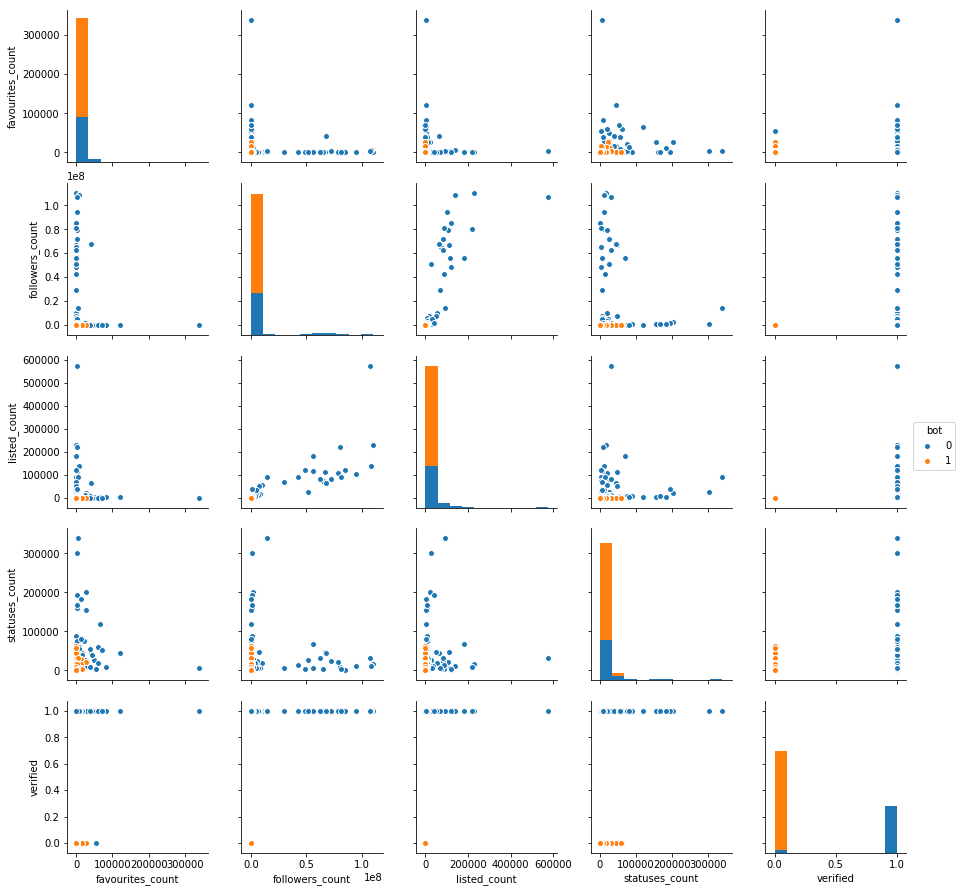

In [26]:
sb.pairplot(df, vars=['favourites_count', 'followers_count', 'listed_count','statuses_count', 'verified'], hue='bot')

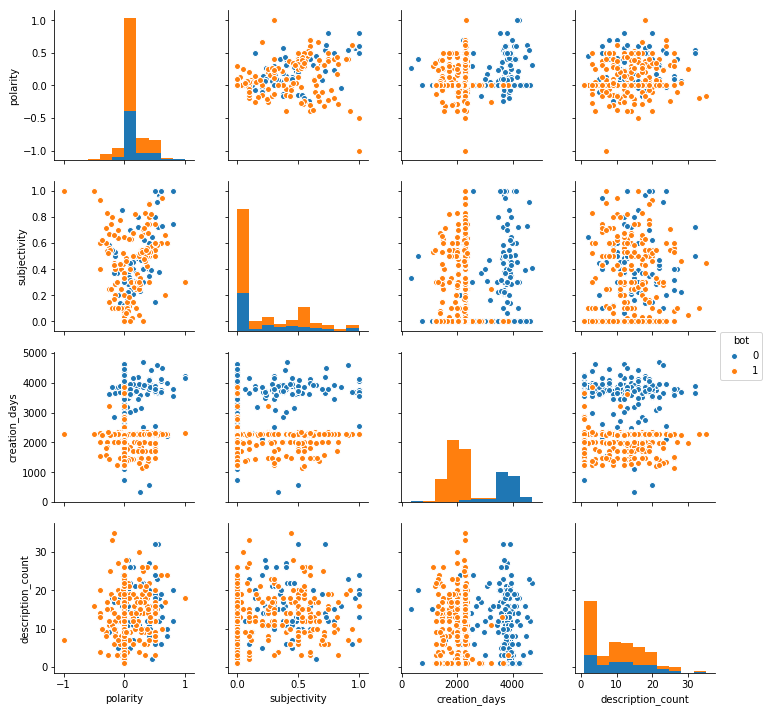

In [28]:
sb.pairplot(df, vars=['polarity', 'subjectivity','creation_days' ,'description_count'], hue='bot')

In [148]:
df.corr()

,favourites_count,followers_count,bot,listed_count,statuses_count,verified,polarity,subjectivity,sentiment,creation_days,description_count
favourites_count,1.000000,0.000137,-0.220152,-0.009520,0.110715,0.206361,-0.005421,0.092920,-0.030803,0.172801,0.096701
followers_count,0.000137,1.000000,-0.324855,0.833149,0.089155,0.338004,0.125185,0.054404,0.061502,0.377365,-0.104952
bot,-0.220152,-0.324855,1.000000,-0.305828,-0.308479,-0.960973,-0.139443,-0.043839,-0.119262,-0.847341,-0.155138
listed_count,-0.009520,0.833149,-0.305828,1.000000,0.202582,0.318026,0.127752,0.042170,0.074702,0.362358,-0.069512
statuses_count,0.110715,0.089155,-0.308479,0.202582,1.000000,0.323420,0.080524,-0.001806,0.061679,0.354825,0.128587
verified,0.206361,0.338004,-0.960973,0.318026,0.323420,1.000000,0.136409,0.047080,0.119967,0.825885,0.156120
polarity,-0.005421,0.125185,-0.139443,0.127752,0.080524,0.136409,1.000000,0.442316,0.803473,0.133905,0.208404
subjectivity,0.092920,0.054404,-0.043839,0.042170,-0.001806,0.047080,0.442316,1.000000,0.341291,0.082124,0.346884
sentiment,-0.030803,0.061502,-0.119262,0.074702,0.061679,0.119967,0.803473,0.341291,1.000000,0.091178,0.206816
creation_days,0.172801,0.377365,-0.847341,0.362358,0.354825,0.825885,0.133905,0.082124,0.091178,1.000000,0.120624


In [135]:
df.to_csv('bot_train.csv')

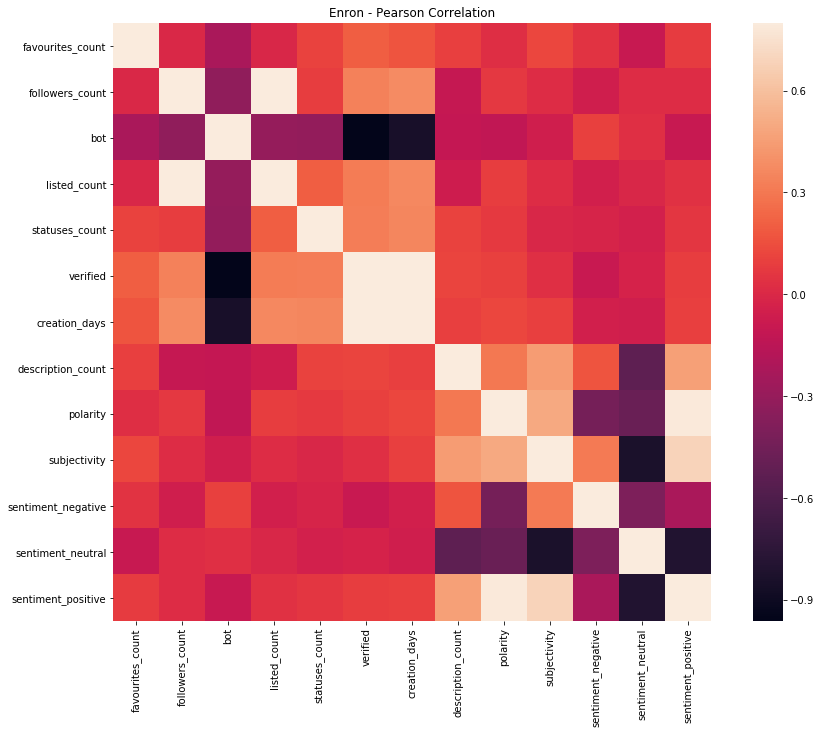

In [77]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 11))

# Draw the heatmap using seaborn
sb.heatmap(corr, vmax=.8, square=True)
plt.title('Enron - Pearson Correlation');

In [79]:
for i in range(1,13):
    pca = PCA(svd_solver='auto', n_components=i)
    x = pca.fit(features_train).explained_variance_ratio_.sum()
    print(i,":", x)

1 : 0.9999910214233253
2 : 0.999996286716994
3 : 0.9999983382833291
4 : 0.9999999973111499
5 : 0.99999999999974
6 : 0.9999999999999972
7 : 0.9999999999999989
8 : 0.9999999999999994
9 : 0.9999999999999997
10 : 0.9999999999999998
11 : 0.9999999999999998
12 : 0.9999999999999998


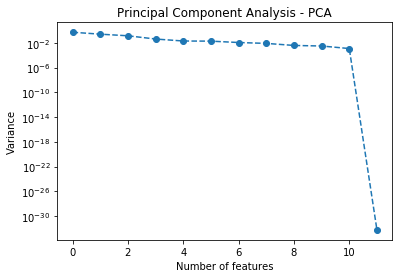

In [80]:
from sklearn.preprocessing import StandardScaler

z_scaler = MinMaxScaler(feature_range=(0, 1))

z_data = z_scaler.fit_transform(features_train)
pca_trafo = PCA().fit(z_data);

plt.semilogy(pca_trafo.explained_variance_ratio_, '--o')
plt.title('Principal Component Analysis - PCA')
plt.xlabel('Number of features')
plt.ylabel('Variance');


# Testing Models

In [37]:
 
from sklearn.metrics import classification_report

models = []
# naive_bayes
models.append(('Naive Bayes', GaussianNB()))
# tree
models.append(('DecisionTree', DecisionTreeClassifier(random_state=42)))
# ensemble
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)))

models.append(('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=100, random_state=42)))
# linear_model
models.append(('LogisticRegression', LogisticRegression(random_state=42)))
# neighbors
models.append(('KNeighbors', KNeighborsClassifier(n_neighbors=5)))
models.append(('NearestCentroid', NearestCentroid()))

accuracy_model = []
score = []
for name, clf in models:  
    tm = time()
    #print "Start testing classifier:", name

    clf.fit(features_train, labels_train)
    predicted = clf.predict(features_test)
    report = classification_report(labels_test, predicted)
    print(name)
    print(report)


Naive Bayes
             precision    recall  f1-score   support

          0       0.94      0.70      0.80        64
          1       0.85      0.97      0.91       108

avg / total       0.88      0.87      0.87       172

DecisionTree
             precision    recall  f1-score   support

          0       0.97      1.00      0.98        64
          1       1.00      0.98      0.99       108

avg / total       0.99      0.99      0.99       172

RandomForest
             precision    recall  f1-score   support

          0       0.98      0.98      0.98        64
          1       0.99      0.99      0.99       108

avg / total       0.99      0.99      0.99       172

GradientBoostingClassifier
             precision    recall  f1-score   support

          0       0.98      0.98      0.98        64
          1       0.99      0.99      0.99       108

avg / total       0.99      0.99      0.99       172

AdaBoost
             precision    recall  f1-score   support

          0 

"\nscores = pd.DataFrame(accuracy_model,\n                     columns=('Model', \n                              'Precision', \n                              'Recall',\n                              'Accuracy')).sort_values(by='Accuracy',\n                                                   ascending = False)\n\nprint(scores)\n"

# Tunning

In [132]:
combined_features = FeatureUnion([("pca", PCA(random_state=42)), 
                                  ('scale', MinMaxScaler(feature_range=(0, 1)))])



pipeline = Pipeline(steps=[('features', combined_features),
                           ('classifier', LogisticRegression(random_state=42))
                          ])

param_grid = {'features__scale': [StandardScaler(with_mean=False), None],
              'features__pca__n_components' :[3,5,6],
              'classifier__C': [0.05, 0.5, 1, 10, 100, 500, 1000],
              'classifier__solver': ['liblinear'],
              'classifier__penalty': ['l2'], 
              'classifier__class_weight': [None, 'balanced']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='f1')

grid.fit(features_train, labels_train)
clf = grid.best_estimator_
#test_classifier(clf, my_dataset, features_list, print_result=True)

In [133]:
y_pred = clf.predict(features_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.09%


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
pipeline = Pipeline([('scale', StandardScaler(with_mean=False)),
                     ('classify', GradientBoostingClassifier(random_state=42))])

param_grid = {
        'classify__criterion': ['mae', 'friedman_mse', 'mse'],
        'classify__n_estimators' : [50, 100, 150],
        'classify__learning_rate':[0.05, 0.1, 1.0],
        'classify__loss' : ['deviance', 'exponential'],    
        'classify__max_leaf_nodes': [100, 150],
        'classify__max_features': [0.50]       
    }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

grid = GridSearchCV(
    pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')

grid.fit(features_train, labels_train)
clf = grid.best_estimator_
#test_classifier(clf, my_dataset, features_list, print_result=True)

In [112]:
cross_val_score(clf, X, y, scoring='recall_macro', cv=5)  

array([0.98068598, 0.98684211, 1.        , 1.        , 0.96710526])

In [85]:
# Adaboost
pipeline = Pipeline(steps=[('minmaxer', StandardScaler(with_mean=False)),
                           ('classifier', DecisionTreeClassifier(random_state=42))
                          ])
params = {
          'classifier__max_features': [2, 6, 10],
          'classifier__min_samples_split' : [0.1, .50, .90],
          'classifier__splitter' : ['best' , 'random'],
          'classifier__min_samples_leaf': [1, 3, 10,15],
          'classifier__class_weight' : ['balanced', None],
          'classifier__criterion': ["gini", "entropy"]
        }

grid = GridSearchCV(pipeline, param_grid = params,scoring = 'recall', cv=10)
grid.fit(features_train, labels_train)

clf_dt = grid.best_estimator_
cross_val_score(clf, X, y, scoring='recall_macro', cv=5)  


array([0.97419247, 0.97368421, 1.        , 0.98684211, 0.96052632])

In [87]:
grid.score(X, y)

1.0

In [128]:
# random Forest
pipeline =   Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                       ('classifier', RandomForestClassifier())
                      ])

param_grid = {'scale': [None, MaxAbsScaler(), MinMaxScaler(feature_range=(0, 1))],
              'classifier__max_depth': [5, 3, 1],
              'classifier__max_features': [2],
              'classifier__min_samples_leaf': [1, 3, 10,15],
              'classifier__bootstrap': [True, False],
              'classifier__criterion': ['gini', 'entropy']
             }

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='recall')

grid.fit(features_train, labels_train)

clf =  grid.best_estimator_
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, scoring='f1', cv=5)  

array([0.97368421, 0.98717949, 0.99346405, 0.99346405, 0.95      ])

In [129]:
print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [130]:
y_pred = clf.predict(features_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.67%


In [163]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y, scoring='recall_macro', cv=5)  

array([0.98717949, 0.98684211, 0.98684211, 1.        , 0.81578947])

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [120]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {  
  'learning_rate': 1,
  'max_depth' :2,
    'gamma':2,
    'eta':0.8,
    'reg_alpha':0.5,
    'reg_lambda':0.5
}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, stratified=True,
                   metrics= ["rmse","auc"], as_pandas=True)
cv_results

,train-auc-mean,train-auc-std,train-rmse-mean,train-rmse-std,test-auc-mean,test-auc-std,test-rmse-mean,test-rmse-std
0,0.993359,0.00204,0.079775,0.007833,0.992004,0.006389,0.090900,0.041345
1,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041268
2,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
3,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
4,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
5,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
6,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
7,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
8,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267
9,0.993359,0.00204,0.079771,0.007835,0.992004,0.006389,0.090946,0.041267


In [124]:
from xgboost import XGBClassifier
#features_train, features_test, labels_train, labels_test
m = XGBClassifier(
    max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
#m.fit(features_train, labels_train)
#m.predict_proba(features_test)[:,1]

model = XGBClassifier(max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5)
model.fit(features_train, labels_train)
# make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.84%


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [134]:
from sklearn.metrics import f1_score
f1 = f1_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.09%


In [118]:
cv_results

,train-auc-mean,train-auc-std,train-rmse-mean,train-rmse-std,test-auc-mean,test-auc-std,test-rmse-mean,test-rmse-std
0,0.999857,0.000104,0.144985,0.005749,0.999574,0.000439,0.154141,0.012653
1,0.999877,0.000090,0.081152,0.009742,0.999208,0.000795,0.100281,0.025114
2,0.999867,0.000101,0.065435,0.011996,0.999208,0.000795,0.088504,0.032838
3,0.999877,0.000090,0.060268,0.012351,0.999229,0.000767,0.085108,0.036124
4,0.999887,0.000081,0.057577,0.012361,0.999189,0.000897,0.083600,0.037078
5,0.999908,0.000067,0.054889,0.011274,0.998906,0.001293,0.082868,0.038673
6,0.999918,0.000063,0.052901,0.010216,0.998745,0.001520,0.082259,0.039590
7,0.999918,0.000063,0.050989,0.008983,0.998745,0.001520,0.081895,0.040556
8,0.999969,0.000025,0.049109,0.008022,0.998825,0.001406,0.081773,0.041341
9,0.999969,0.000025,0.047347,0.007038,0.998664,0.001633,0.081804,0.042122


In [108]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[21:34:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# ml bq

In [ ]:
CREATE MODEL `capstonettw.spot_bot`
OPTIONS (
  model_type='logistic_reg',
  data_split_method='AUTO_SPLIT'
) AS
SELECT * EXCEPT (bot),
        bot as label
from capstonettw.train_bot;\

In [ ]:
sql = 
    WITH game_to_predict AS (
        SELECT
            *
        FROM
            `bqml_tutorial.wide_games`
        WHERE
            game_id='f1063e80-23c7-486b-9a5e-faa52beb2d83' )
    SELECT
        truth.game_id AS game_id,
        total_three_points_att,
        predicted_total_three_points_att
    FROM (
        SELECT
            game_id,
            predicted_label AS predicted_total_three_points_att
        FROM
            ML.PREDICT(MODEL `bqml_tutorial.ncaa_model`,
            table game_to_predict) ) AS predict
    JOIN (
        SELECT
            game_id,
            total_three_points_att AS total_three_points_att
        FROM
            game_to_predict) AS truth
    ON
        predict.game_id = truth.game_id
"""
df = client.query(sql).to_dataframe()
print(df)